### Introduction
In active learning (AL), we use a machine learning (ML) model as a surrogate for a more computationally expensive method.  Let's say we want to dock millions of molecules, but have limited computational resources.  We could sample a subset of the molecules we want to dock and dock the subset.  The chemical structures and docking scores for the subset could then be used to build an ML model to predict the docking scores for the entire set of molecules. In AL, we perform multiple cycles of this prediction and sampling workflow. Throughout the process, we want to balance two parameters.
- Exploration - efficiently search the chemical space and identify the most promising regions
- Explotation - focus the search on the most interesting regions of chemical space

This process is illustrated in the figure below.
<br>
<center><img src="active_learning.png" alt="active learning figure" width="800"/></center>

1. Begin with a pool of M molecules
2. Sample N molecules from the pool
3. Perform the computationally expensive calculations on the subset of N molecules.  If our objective is docking, we dock the N molecules.
4. The chemical structures and docking scores for the N molecules are used to build an ML model
5. The model from step 4 ised to predict values for the M molecules from step 1
6. The predictions from the previous step are used to select another set of N molecules.  There are several ways to do this.  One of the simplest is a **greedy** search where we select the N best scoring molecules.  Alternately, we can employ strategies that use the uncertainty in the predictions to direct exploration.
7. Perform the computationally expensive calculations on the molecules selected in step 6. If our objective is docking, we would dock the N molecules.
8. The results from step 7 are combined with the results from step 3 and the model is retrained.
Steps 4 through 8 can be repeated multiple times

In the example below, we use AL to dock a set of 100K molecules.  To make this exercise more time efficient, we'll look up the activity rather performing the docking. The code below uses modAL, an open source library for active learning. Modal provides several different AL strategies.

### Setup

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import useful_rdkit_utils as uru
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm

Enable Pandas **progress_apply**

In [2]:
tqdm.pandas()

Read data from ["Traversing Chemical Space with Active Deep Learning"](https://chemrxiv.org/engage/chemrxiv/article-details/654a603348dad23120461847) by Derek van Tilborg and Francesca Grisoni. 

The data is formatted with SMILES and 1 or 0 inidicating active or inactive. 
<pre>
smiles,y
COc1cc(/C=N/NC(=O)C(=O)NCC2CCCO2)ccc1O,0
CC1CCCCC12NC(=O)N(CC(=O)Nc1ccc(N3CCOCC3)cc1)C2=O,0
C[NH+]1CCCC(OC(=O)c2cccc(Cl)c2)C1,0
CCOc1ccc(C(=O)NCC(=O)OCC(=O)N2CCCC2)cc1,0
</pre>

In [3]:
df = pd.read_csv("screen.csv")
df['fp'] = df.smiles.progress_apply(uru.smi2numpy_fp)

  0%|          | 0/100000 [00:00<?, ?it/s]

Convert the data to numpy arrays

In [4]:
% % time
X_pool = np.stack(df.fp.values)
y_pool = df.y.values

CPU times: user 3min 15s, sys: 2.07 s, total: 3min 17s
Wall time: 3min 18s


### Initial Model
Define an oracle to return the results of our calcuation.  In this case, we're just looking up a value.  In practice an oracle might perform docking calcuations or something else that's more compute itensive.

In [5]:
class Oracle:
    def __init__(self, df):
        self.df = df

    def get_values(self, idx_list):
        return df.y.values[idx_list]

Select a set of molecules to build and initial model.  In this case, we'll randomly select 100 molecules and use this set of 100 to build an ML model. 

In [6]:
n_initial = 100
initial_list = np.random.choice(range(len(df)), size=n_initial, replace=False)

Select 100 examples to build the initial model

In [7]:
X_training = X_pool[initial_list]
y_training = y_pool[initial_list]

### Active Learning
Define an ActiveLearner.  This class holds the ML model used to preform the active learning.

In [8]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_training, y_training=y_training
)

Instantiate an oracle.  As mentioned above, this is a simple lookup. 

In [9]:
oracle = Oracle(df)

Run 10 cycles of active learning

In [10]:
# Define a list to keep track of the molecules we've selected
pick_list = initial_list
# How many molecules we will select at each iteration
n_instances = 100
for i in range(0, 10):
    # Use the model to select the next set of molecules
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    # Use the oracle to look up the value
    y_new = oracle.get_values(query_idx)
    # Use the values from the oracle to update the model
    learner.teach(X_pool[query_idx], y_pool[query_idx])
    # Add the picks to pick_list
    pick_list = np.append(pick_list, query_idx)
    # How many active molecules have we found
    print(sum(y_pool[pick_list]))

33
61
79
86
103
133
158
196
218
250


### Compare With a Random Baseline
That looks pretty good, but we should compare with a random baseline.  Let's run 10 random trails and see how many active moleucles we find.

In [11]:
random_hit_count_list = []
for i in range(0, 10):
    random_list = np.random.choice(range(len(df)), size=1000, replace=False)
    random_hit_count_list.append(sum(df.y.values[random_list]))

Now lets run 10 active learning trials.  To do this, we'll write a function that encapsulates the code we wrote above.

In [12]:
def run_active_learning(X, y, oracle, num_cycles=10):
    initial_list = np.random.choice(range(len(df)), size=n_initial, replace=False)
    pick_list = initial_list
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_training, y_training=y_training
    )
    for i in tqdm(range(0, num_cycles)):
        query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
        y_new = oracle.get_values(query_idx)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        pick_list = np.append(pick_list, query_idx)
    return sum(y[pick_list])

In [13]:
active_learning_hit_count_list = []
for i in range(0, 10):
    num_hits = run_active_learning(X_pool, y_pool, oracle)
    active_learning_hit_count_list.append(num_hits)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
random_df = pd.DataFrame(random_hit_count_list)
random_df.columns = ["count"]
random_df['category'] = "random"
active_df = pd.DataFrame(active_learning_hit_count_list)
active_df.columns = ["count"]
active_df['category'] = "active"
plot_df = pd.concat([random_df, active_df])

<Axes: xlabel='category', ylabel='count'>

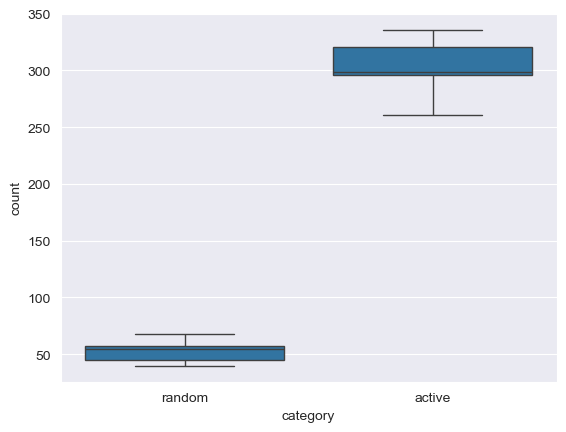

In [15]:
sns.boxplot(plot_df, x="category", y="count")

In [16]:
np.mean(active_learning_hit_count_list) / np.mean(random_hit_count_list)

5.808795411089867